In [1]:
from itertools import chain

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

In [3]:
import torch

In [4]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython import display

matplotlib.rcParams['figure.figsize'] = (18, 12)
matplotlib.rcParams['figure.titlesize'] = 24
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 28
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 17
matplotlib.rcParams['ytick.labelsize'] = 17
matplotlib.rcParams['axes.grid'] = True

In [5]:
from net import ResNet20
from loader import testloader
from train import get_accuracy

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
res_net = ResNet20()
res_net.load_state_dict(torch.load('./res_net_20.model'))
res_net.cuda();

In [7]:
get_accuracy(res_net, testloader)

0.9074000000000002

In [8]:
def plot_error_history(ax, test_accuracies, ymin=0.05, ymax=0.7):
    ax.cla()
    ax.plot(1 - np.array(test_accuracies), '-o')
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Номер сверточного слоя')
    ax.set_ylabel('Ошибка на тестовом сете')
    ax.set_title('Зависимость ошибки от индекса слоя, до которого дошел pruning')
    ax.hlines(0.1,0, len(test_accuracies), colors='r', linestyle='dotted', linewidth=4)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [9]:
def fit_transform_weights(weight, n_clusters, method='kmeans'):
    n_filters = weight.shape[0]
    initial_shape = weight.shape
    weight = weight.cpu().detach().numpy().reshape((n_filters, -1))
    if method == 'kmeans':
        cluster_model = KMeans(n_clusters).fit(weight)
        weight_pruned = cluster_model.cluster_centers_[cluster_model.predict(weight)]
    elif method == 'pca':
        cluster_model = TruncatedSVD(n_components=n_clusters).fit(weight)
        weight_pruned = cluster_model.inverse_transform(cluster_model.transform(weight))
    else:
        raise ValueError(f'unknown clustering method: {method}')
    return torch.from_numpy(weight_pruned.reshape(initial_shape)).cuda()

## Попробуем оставить 7 / 8 фильтров в каждом слое

In [10]:
print(f'Кол-во параметров сети уменьшается на {100.0 * (1 - 7 / 8)}%')

Кол-во параметров сети уменьшается на 12.5%


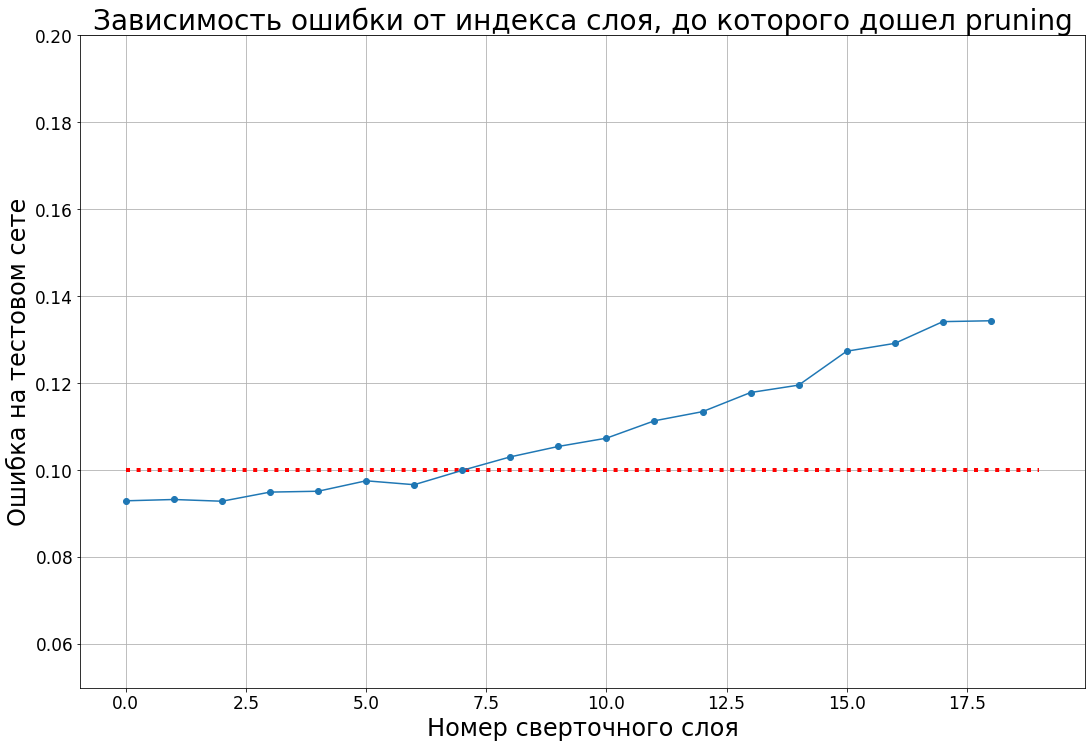

In [11]:
res_net = ResNet20()
res_net.load_state_dict(torch.load('./res_net_20.model'))
res_net.cuda();
fig, ax = plt.subplots()
test_accuracies = []
for l in res_net.get_all_convolutional_layers():
    n_filters = l.weight.shape[0]
    n_clusters = 7 * (n_filters // 8)
    l.weight = torch.nn.Parameter(fit_transform_weights(l.weight, n_clusters, method='kmeans'))
    test_accuracies.append(get_accuracy(res_net, testloader))
    plot_error_history(ax, test_accuracies, ymax=0.2)

In [12]:
print(f'Ошибка после прунинга 1/8 фильтров составила: {1 - get_accuracy(res_net, testloader)}')

Ошибка после прунинга 1/8 фильтров составила: 0.13439999999999996


### Ошибка выросла значительно, вряд ли такое качество нас устроит, зато из графика выше видно, что после прунинга первых 7 слоев ошибка оставалась ниже 10%.

### Попробуем теперь другой метод кластеризации -- метод главных компонент

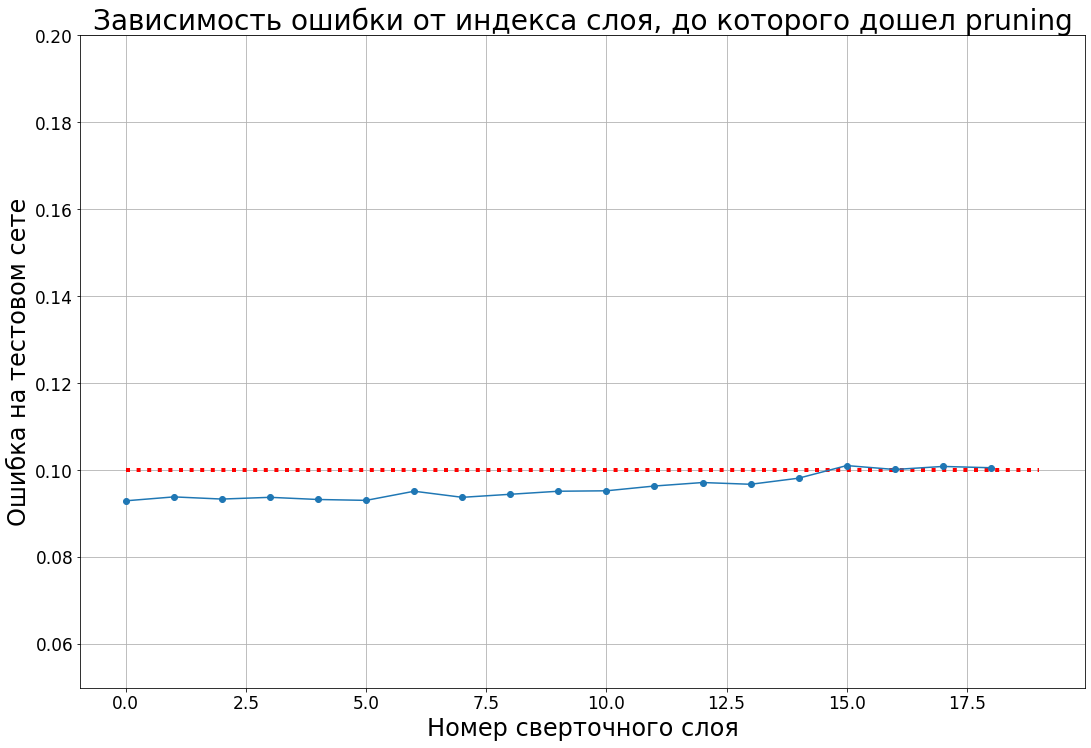

In [13]:
res_net = ResNet20()
res_net.load_state_dict(torch.load('./res_net_20.model'))
res_net.cuda();
fig, ax = plt.subplots()
test_accuracies = []
for l in res_net.get_all_convolutional_layers():
    n_filters = l.weight.shape[0]
    n_clusters = 7 * (n_filters // 8)
    l.weight = torch.nn.Parameter(fit_transform_weights(l.weight, n_clusters, method='pca'))
    test_accuracies.append(get_accuracy(res_net, testloader))
    plot_error_history(ax, test_accuracies, ymax=0.2)

In [14]:
print(f'Ошибка после прунинга 1/8 фильтров составила: {1 - get_accuracy(res_net, testloader)}')

Ошибка после прунинга 1/8 фильтров составила: 0.10059999999999991


Видно, что результаты метода главных компонент значительно лучше, чем у метода K-средних. Но метод главных компонент имеет довольно важное отличие от метода K-средних: 
* в методе K-средних мы просто заменяли фильтр на ближайший к нему центроид, поэтому при инференсе в продакшн мы просто можем вычислить свертки с фильтрами-центроидами, и подставить результаты в нужные каналы и передать тензор на след слой
* в методе главных компонент по сути каждый фильтр представляется линейной комбинацией главных компонент. мы тоже можем вычислить свертки для каждой главной компоненты, но потом придется для каждого канала выходного тензора вычислять лин комбинацию результатов для главных компонент. Это может плохо влиять на время инференса плюс нам для каждого сворточного слоя придется хранить матрицу U (n_filters, n_components) в которой для каждого фильтра будет записано с какими весами брать каждую из главных компонент.

В методе K-средних в матрице U в каждой строке все веса, кроме одного, равны нулю, а этот один вес равен 1.0, т.е. хранить нужно значительно меньше данных. Но качество K-средних хуже.
Поэтому кажется, что нужен компромисс -- нужно чтобы матрица весов U (n_filters, n_components) была бы с одной стороны как можно более разрежена, с другой стороны чтобы с ее помощью хорошо приближались вектора исходных фильтров.
Например, можно попровать выучить pca-разложение, где метрикой будет не только MSE между исходной матрицей и восстановленной, но и L1-регуляризация, наложеннная на веса матрицы U (n_filters, n_components). 